In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
import librosa
from google.colab import drive
import os

# Mount Google Drive for access
drive.mount('/content/drive')

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from JSON files training with MFCC and overlap
with open('/content/drive/MyDrive/My-207/X_train.json', 'r') as file:
    X_train_list = json.load(file)
    X_train = np.array(X_train_list)

with open('/content/drive/MyDrive/My-207/y_train.json', 'r') as file:
    y_train_list = json.load(file)
    y_train = np.array(y_train_list)

# Load data from JSON files
with open('/content/drive/MyDrive/My-207/X_val.json', 'r') as file:
    X_val_list = json.load(file)
    X_val = np.array(X_val_list)

with open('/content/drive/MyDrive/My-207/y_val.json', 'r') as file:
    y_val_list = json.load(file)
    y_val = np.array(y_val_list)


In [ ]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Save the label encoder for later use
label_encoder_path = "label_encoder.pkl"
import joblib
joblib.dump(label_encoder, label_encoder_path)

print(X_train.shape)
print(X_val.shape)

(7889, 20, 157)
(3121, 20, 157)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_X_reshape = X_train.reshape(-1, 20*157)
val_X_reshape = X_val.reshape(-1, 20*157)

scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

train_X_scaled = scaler.transform(train_X_reshape)
val_X_scaled = scaler.transform(val_X_reshape)

X_train = train_X_scaled.reshape(-1,20,157)
X_val = val_X_scaled.reshape(-1,20,157)

print(X_train.shape)
print(X_val.shape)


(7889, 20, 157)
(3121, 20, 157)


In [ ]:
# swap the x and y axis so doing convolution on the time dimension
train_X_perm = []
for each in X_train:
  train_X_perm.append(np.transpose(each))

X_train = np.array(train_X_perm)

val_X_perm = []
for each in X_val:
  val_X_perm.append(np.transpose(each))

X_val = np.array(val_X_perm)

print(X_train.shape)
print(X_val.shape)

(7889, 157, 20)
(3121, 157, 20)


In [ ]:
from sklearn.utils import shuffle
train_X, train_y = shuffle(X_train, y_train, random_state=1234)
val_X, val_y = shuffle(X_val, y_val, random_state=1234)

In [ ]:
# # Data normalization
# scaler = StandardScaler()

# # Flatten X_train into a 2-dimensional array
# X_train = X_train.reshape(X_train.shape[0], -1)

# # Fit and transform the training data
# X_train = scaler.fit_transform(X_train)

# # Flatten X_val into a 2-dimensional array
# X_val = X_val.reshape(X_val.shape[0], -1)

# # Transform the validation data using the scaler parameters from the training data
# X_val = scaler.transform(X_val)

# # Convert string labels to numerical labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_val_encoded = label_encoder.transform(y_val)

# # One-hot encode the labels for LSTM
# y_train_onehot = to_categorical(y_train_encoded)
# y_val_onehot = to_categorical(y_val_encoded)

# # Save the label encoder for later use
# label_encoder_path = "label_encoder.pkl"
# import joblib
# joblib.dump(label_encoder, label_encoder_path)

# # Reshape the data for LSTM (add additional dimension for time steps)
# X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
# One-hot encode labels
from tensorflow.keras.utils import to_categorical

# One-hot encoding the target variables
y_train_hot = to_categorical(y_train_encoded)
y_val_hot = to_categorical(y_val_encoded)



In [ ]:

# Build LSTM model topology
model = tf.keras.Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])




In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 157, 128)          76288     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 125,891
Trainable params: 125,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train_hot, validation_data=(X_val, y_val_hot), batch_size=32, epochs=5)


Epoch 1/5
247/247 [==============================] - 113s 441ms/step - loss: 0.9911 - accuracy: 0.4968 - val_loss: 0.9657 - val_accuracy: 0.5043
Epoch 2/5
247/247 [==============================] - 101s 409ms/step - loss: 0.9060 - accuracy: 0.5671 - val_loss: 0.9102 - val_accuracy: 0.5633
Epoch 3/5
247/247 [==============================] - 101s 410ms/step - loss: 1.0307 - accuracy: 0.4501 - val_loss: 1.0114 - val_accuracy: 0.5226
Epoch 4/5
247/247 [==============================] - 95s 385ms/step - loss: 0.9618 - accuracy: 0.5479 - val_loss: 0.9388 - val_accuracy: 0.5098
Epoch 5/5
247/247 [==============================] - 102s 412ms/step - loss: 1.0155 - accuracy: 0.4733 - val_loss: 1.0936 - val_accuracy: 0.3361


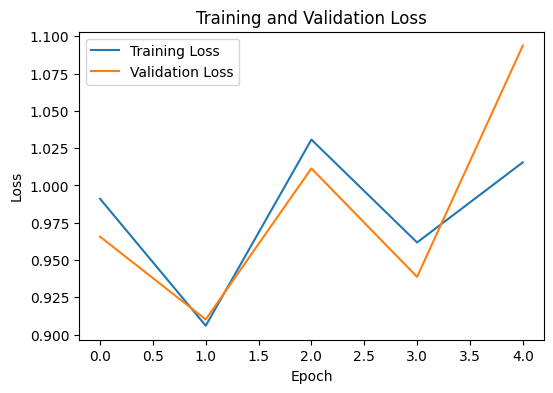

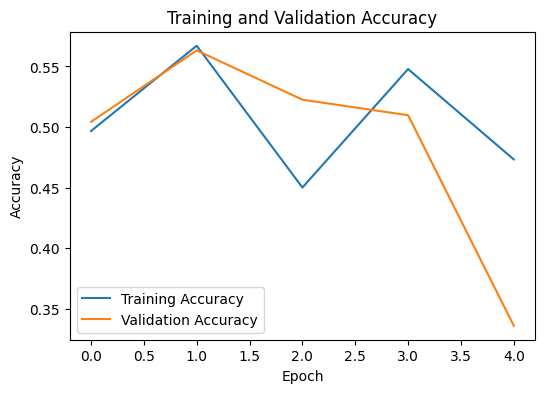

In [ ]:

# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

98/98 [==============================] - 12s 125ms/step
F1 Score: 0.25421317921361813

              precision    recall  f1-score   support

      barswa       0.35      0.80      0.48      1056
      comsan       0.30      0.18      0.22       972
     eaywag1       0.30      0.03      0.06      1093

    accuracy                           0.34      3121
   macro avg       0.32      0.34      0.26      3121
weighted avg       0.32      0.34      0.25      3121



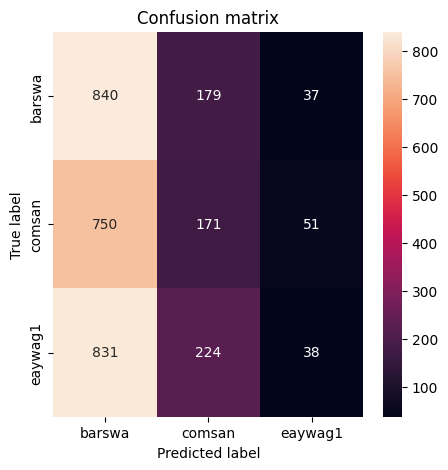

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from tensorflow.math import confusion_matrix

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1 score
f1 = f1_score(y_val_encoded, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}\n')

# Generate a classification report
report = classification_report(y_val_encoded, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# Create a confusion matrix
conf_mat = confusion_matrix(y_val_encoded, y_pred_classes).numpy()

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

